In [21]:
using DrWatson
@quickactivate
include(srcdir("main.jl"))
using DataFrames
using DataFramesMeta
using AlgebraOfGraphics

In [22]:
dfs = collect_results(datadir("simulations"));

┌ Info: Scanning folder /Users/zijin/projects/ion_scattering_by_SWD/data/simulations for result files.
└ @ DrWatson /Users/zijin/.julia/packages/DrWatson/8XYbJ/src/result_collection.jl:117
┌ Info: Added 6 entries.
└ @ DrWatson /Users/zijin/.julia/packages/DrWatson/8XYbJ/src/result_collection.jl:193


In [23]:
cos_pitch_angle(u, α, β) = cos_pitch_angle(u, RD_B_field(u, α, β))

df = vcat(dfs[:,:result]...);

@chain df begin
    @rtransform!(:u1 = :u[end])
    @rtransform!(
        :w0 = cos_pitch_angle(:u0, :α, :β),
        :w1 = cos_pitch_angle(:u1, :α, :β)
    )
    @transform!(
        :Δw = :w1 .- :w0,
    )
end;

In [51]:
sym_text_func(s::Symbol) = x -> "$(s) = $(round(x, digits=2))"

αs = unique(dfs.α)
vs = unique(dfs.v) |> sort

α_renamer = renamer([α => "α = $(round(α, digits=2))" for α in αs])
v_renamer = renamer([v => "v = $(round(v, digits=2))" for v in vs])

Δw_map = :Δw
α_map = :α => α_renamer
β_map = :β => sym_text_func(:β)
v_map = :v => v_renamer

:v => AlgebraOfGraphics.Renamer{Vector{Int64}, Vector{String}}([1, 8, 64], ["v = 1.0", "v = 8.0", "v = 64.0"])

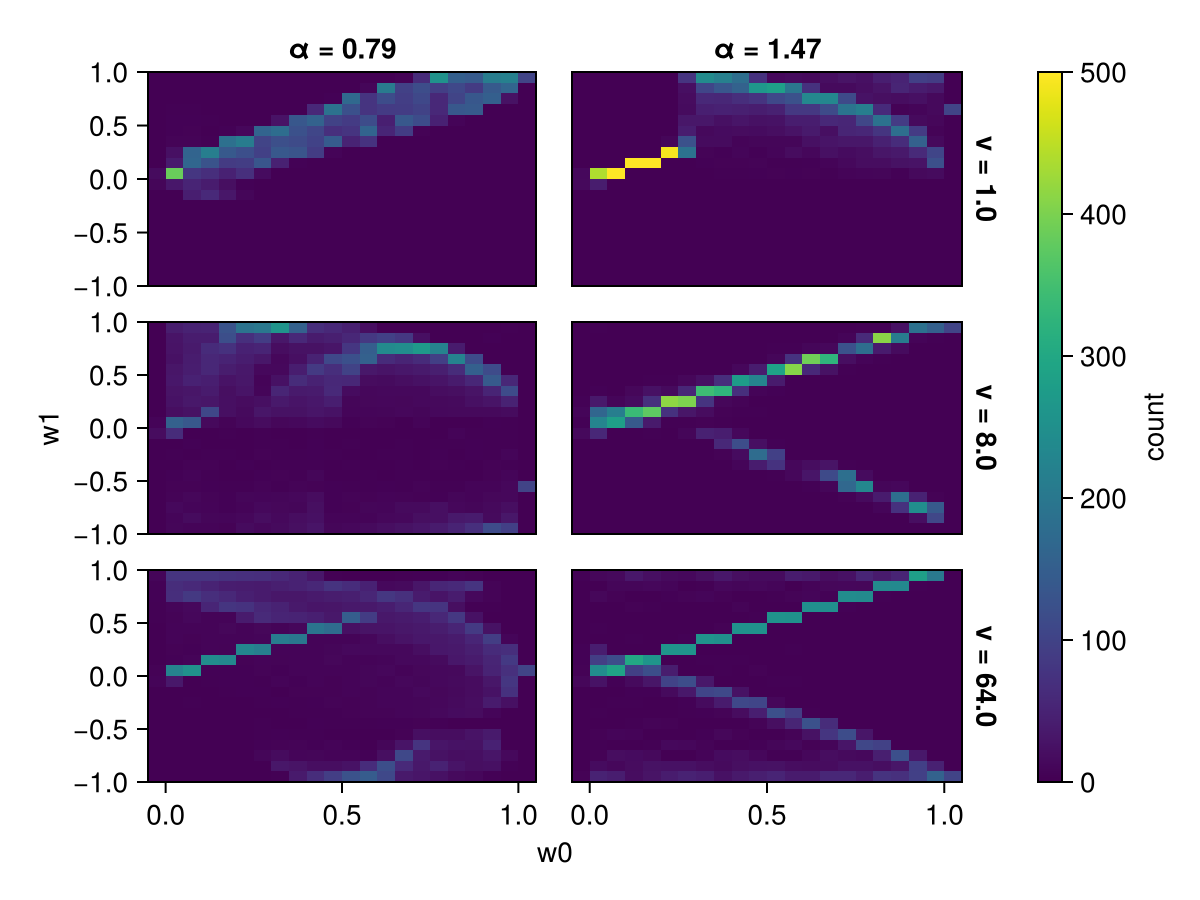

In [52]:
function pa_pair_plot(df::AbstractDataFrame)
    pa_pair_plot(data(df))
end

function pa_pair_plot(layer)
    # Plot the distribution of pitch-angle cosine variation using AlgebraOfGraphics
    plt = layer * mapping(:w0, :w1;) * histogram(bins=32) 
    # axis=(; xlabel="Δw", ylabel="f(Δw)", title="Distribution of Pitch-Angle Cosine Variation")
    # axis=(; colorscale=log10)
    axis = (;)
    draw(plt; axis=axis)

    # color = :v => nonnumeric
end

function pa_diff_plot(layer)
    plt = layer * mapping(:Δw) * histogram(bins=32) 
    axis=(; xlabel="Δw", ylabel="f(Δw)")
    draw(plt; axis=axis)
end


layer = data(df) * mapping(col = α_map, row = v_map)
pa_pair_plot(layer)

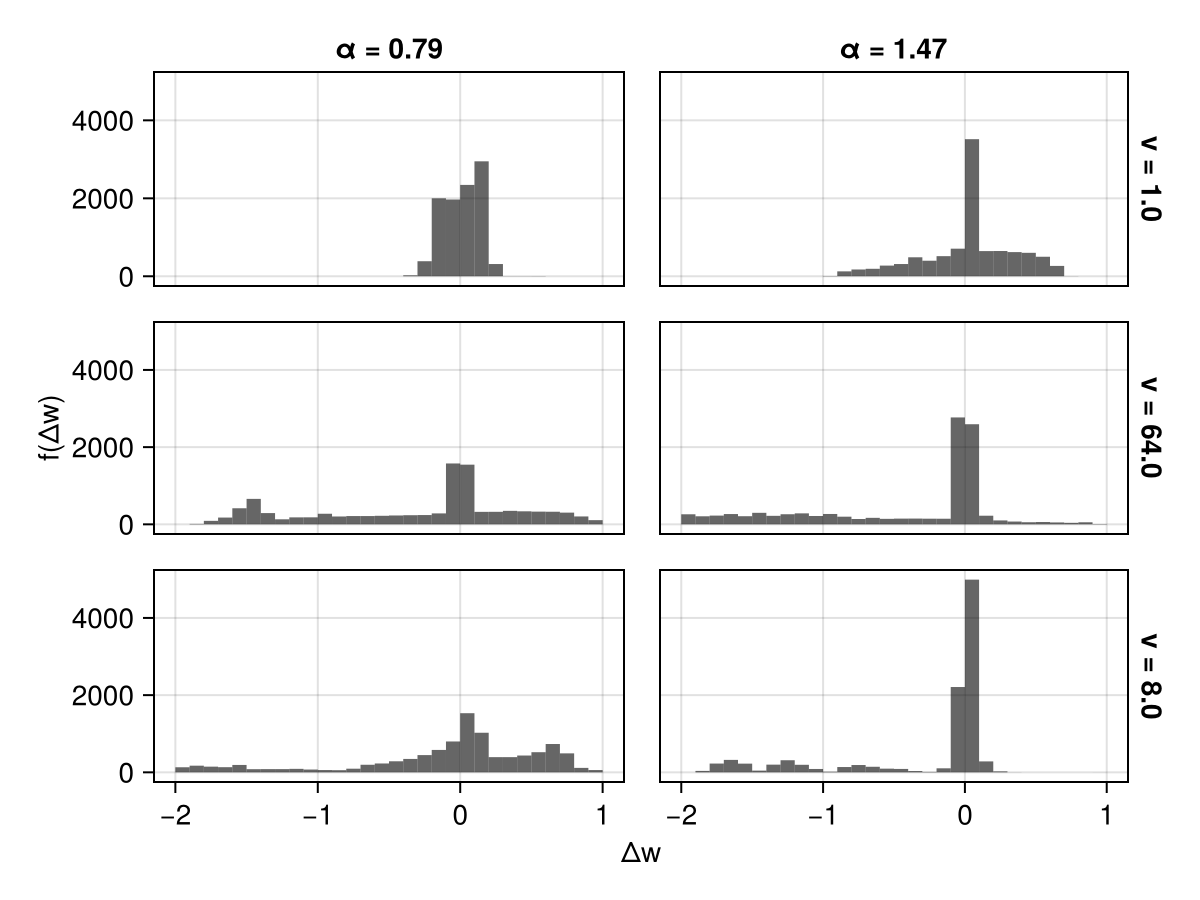

In [26]:
pa_diff_plot(layer)

In [ ]:
# sols, sol_field = sim(d)
# Step 4: Visualization
# plot_trajectory(d) = plot_trajectory(sim(d)...)
# f = plot_trajectory(sols, sol_field)
# plot_trajectory(d)

In [13]:


function d_cos_pitch_angle(sol)
    return cos_pitch_angle(sol, 1) - cos_pitch_angle(sol, length(sol))
end

function d_cos_pitch_angle(sol::EnsembleSolution)
    return map(sol) do s
        d_cos_pitch_angle(s)
    end
end

d_cos_pitch_angle (generic function with 2 methods)

In [15]:
df[!, :Δw] = d_cos_pitch_angle.(df[!, :result]);

MethodError: MethodError: objects of type JLD2.ReconstructedStatic{Symbol("Field{false,JLD2.ReconstructedStatic{Symbol(\"#119#122{Float64,Float64}\"), (:α, :β), Tuple{Float64, Float64}}}"), (:field_function,), Tuple{JLD2.ReconstructedStatic{Symbol("#119#122{Float64,Float64}"), (:α, :β), Tuple{Float64, Float64}}}} are not callable